# （2）- Data Mining

In [1]:
# 导入相关包
%matplotlib inline
# 绘图包
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
#定义文件名
ACTION_201602_FILE = "data/JData_Action_201602.csv"
ACTION_201603_FILE = "data/JData_Action_201603.csv"
ACTION_201604_FILE = "data/JData_Action_201604.csv"
COMMENT_FILE = "data/JData_Comment.csv"
PRODUCT_FILE = "data/JData_Product.csv"
USER_FILE = "data/JData_User.csv"
USER_TABLE_FILE = "data/User_table.csv"
ITEM_TABLE_FILE = "data/Item_table.csv"

## 周一到周日各天购买情况

In [5]:
# 提取购买(type=4)的行为数据
def get_from_action_data(fname, chunk_size=50000):
    reader = pd.read_csv(fname, header=0, iterator=True)
    chunks = []
    loop = True
    while loop:
        try:
            chunk = reader.get_chunk(chunk_size)[
                ["user_id", "sku_id", "type", "time"]]
            chunks.append(chunk)
        except StopIteration:
            loop = False
            print("Iteration is stopped")

    df_ac = pd.concat(chunks, ignore_index=True)
    df_ac = df_ac[df_ac['type'] == 4] # type=4,为购买

    return df_ac[["user_id", "sku_id", "time"]]

In [4]:
df_ac = []
df_ac.append(get_from_action_data(fname=ACTION_201602_FILE))
df_ac.append(get_from_action_data(fname=ACTION_201603_FILE))
df_ac.append(get_from_action_data(fname=ACTION_201604_FILE))
df_ac = pd.concat(df_ac, ignore_index=True)

Iteration is stopped
Iteration is stopped
Iteration is stopped


In [10]:
print(df_ac.dtypes)
pd.set_option('max_rows',15) #设置最大显示20行
df_ac

user_id     int64
sku_id      int64
time       object
dtype: object


,user_id,sku_id,time
0,269365,166345,2016-02-01 00:01:00
1,235443,36692,2016-02-01 00:02:00
2,247689,9112,2016-02-01 00:03:00
3,273959,102034,2016-02-01 00:05:00
4,226791,163550,2016-02-01 00:06:00
5,301962,125188,2016-02-01 00:08:00
6,246290,125188,2016-02-01 00:08:00
...,...,...,...
48245,254442,737,2016-04-15 23:48:00
48246,302346,20819,2016-04-15 23:50:00


#### pd.to_datetime()将object类型转化为datetime类型

In [34]:
# 将time字段转换为datetime类型
df_ac['time'] = pd.to_datetime(df_ac['time'])

# 使用lambda匿名函数将时间time转换为星期(周一为1, 周日为７)
df_ac['time'] = df_ac['time'].apply(lambda x: x.weekday() + 1) #weekday是从0开始的，所以+1为从1开始

In [35]:
df_ac.head()

,user_id,sku_id,time
0,269365,166345,1
1,235443,36692,1
2,247689,9112,1
3,273959,102034,1
4,226791,163550,1


In [40]:
# 周一到周日每天购买用户个数
df_user = df_ac.groupby('time')['user_id'].nunique() #只统计购买的用户，不统计购买的量
df_user = df_user.to_frame().reset_index()
df_user.columns = ['weekday', 'user_num']

In [52]:
df_ac.groupby('time')['user_id'].nunique().to_frame()

,user_id
time,
1,6162
2,6946
3,5001
4,6409
5,6049
6,4174
7,3710


In [41]:
# 周一到周日每天购买商品个数
df_item = df_ac.groupby('time')['sku_id'].nunique()
df_item = df_item.to_frame().reset_index()
df_item.columns = ['weekday', 'item_num']

In [56]:
df_item

,weekday,item_num
0,1,1844
1,2,1996
2,3,1800
3,4,1805
4,5,1855
5,6,1643
6,7,1578


In [48]:
# 周一到周日每天购买记录个数
df_ui = df_ac.groupby('time', as_index=False).size() #等于df_ac.groupby('time', as_index=False)['user_id'].size()
df_ui = df_ui.to_frame().reset_index()
df_ui.columns = ['weekday', 'user_item_num']

In [47]:
df_ac.groupby('time', as_index=False)['user_id'].size()

time
1    7759
2    8869
3    6262
4    8078
5    7505
6    5143
7    4636
dtype: int64

### 条形统计图

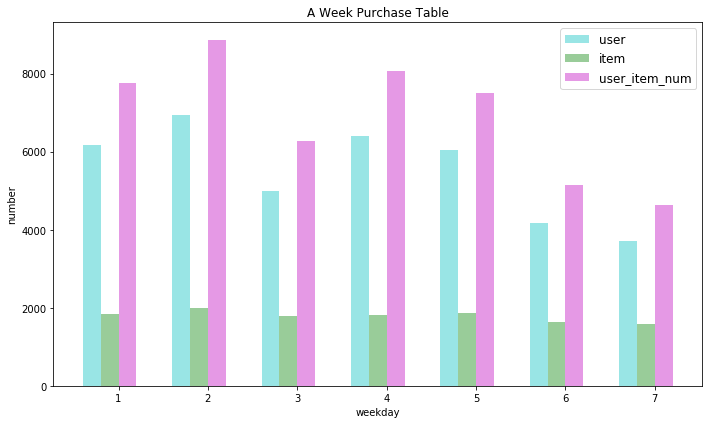

In [60]:
# 条形宽度
bar_width = 0.2
# 透明度
opacity = 0.4

plt.figure(figsize=(10,6))

plt.bar(df_user['weekday'], df_user['user_num'], bar_width, 
        alpha=opacity, color='c', label='user')
plt.bar(df_item['weekday']+bar_width, df_item['item_num'], 
        bar_width, alpha=opacity, color='g', label='item')
plt.bar(df_ui['weekday']+bar_width*2, df_ui['user_item_num'], 
        bar_width, alpha=opacity, color='m', label='user_item_num') #user_item_num用户购买次数

plt.xlabel('weekday')
plt.ylabel('number')
plt.title('A Week Purchase Table')
plt.xticks(df_user['weekday'] + bar_width * 3 / 2., (1,2,3,4,5,6,7))
plt.tight_layout() 
plt.legend(prop={'size':12})

分析：周六，周日购买量较少

## 一个月中各天购买量

### 2016年2月

In [61]:
df_ac = get_from_action_data(fname=ACTION_201602_FILE)

# 将time字段转换为datetime类型并使用lambda匿名函数将时间time转换为天
df_ac['time'] = pd.to_datetime(df_ac['time']).apply(lambda x: x.day)

Iteration is stopped


In [65]:
df_ac.head()

,user_id,sku_id,time
351,269365,166345,1
649,235443,36692,1
980,247689,9112,1
1719,273959,102034,1
2153,226791,163550,1


In [66]:
df_ac.tail()

,user_id,sku_id,time
11464511,256461,126092,29
11470852,224347,137636,29
11478541,300214,102335,29
11480871,213442,48000,29
11483928,228994,165190,29


In [74]:
df_user = df_ac.groupby('time')['user_id'].nunique()
df_user = df_user.to_frame().reset_index()
df_user.columns = ['day', 'user_num']

df_item = df_ac.groupby('time')['sku_id'].nunique()
df_item = df_item.to_frame().reset_index()
df_item.columns = ['day', 'item_num']

df_ui = df_ac.groupby('time', as_index=False).size()
df_ui = df_ui.to_frame().reset_index()
df_ui.columns = ['day', 'user_item_num']

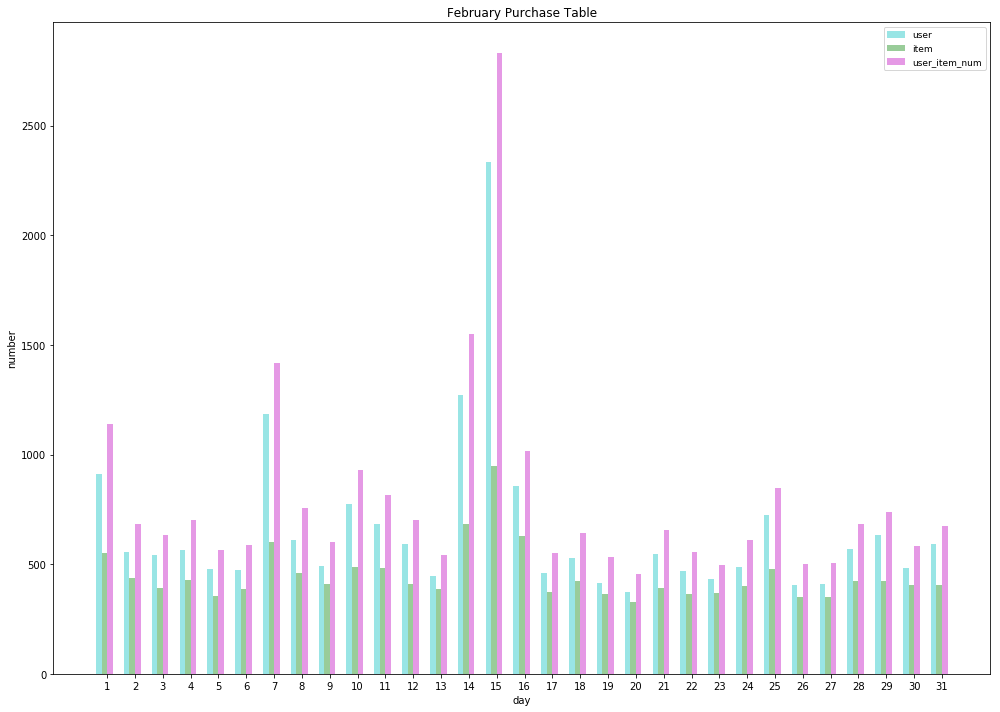

In [83]:
# 条形宽度
bar_width = 0.2
# 透明度
opacity = 0.4
# 天数
day_range = range(1,len(df_user['day']) + 1, 1)
# 设置图片大小
plt.figure(figsize=(14,10))

plt.bar(df_user['day'], df_user['user_num'], bar_width, 
        alpha=opacity, color='c', label='user')
plt.bar(df_item['day']+bar_width, df_item['item_num'], 
        bar_width, alpha=opacity, color='g', label='item')
plt.bar(df_ui['day']+bar_width*2, df_ui['user_item_num'], 
        bar_width, alpha=opacity, color='m', label='user_item_num')

plt.xlabel('day')
plt.ylabel('number')
plt.title('February Purchase Table')
plt.xticks(df_user['day'] + bar_width * 3 / 2., day_range)
# plt.ylim(0, 80)
plt.tight_layout() 
plt.legend(prop={'size':9})

分析： 2月份5,6,7,8,9,10 这几天购买量非常少，原因可能是中国农历春节，快递不营业

### 2016年3月

In [80]:
df_ac = get_from_action_data(fname=ACTION_201603_FILE)

# 将time字段转换为datetime类型并使用lambda匿名函数将时间time转换为天
df_ac['time'] = pd.to_datetime(df_ac['time']).apply(lambda x: x.day)

Iteration is stopped


In [81]:
df_user = df_ac.groupby('time')['user_id'].nunique()
df_user = df_user.to_frame().reset_index()
df_user.columns = ['day', 'user_num']

df_item = df_ac.groupby('time')['sku_id'].nunique()
df_item = df_item.to_frame().reset_index()
df_item.columns = ['day', 'item_num']

df_ui = df_ac.groupby('time', as_index=False).size()
df_ui = df_ui.to_frame().reset_index()
df_ui.columns = ['day', 'user_item_num']

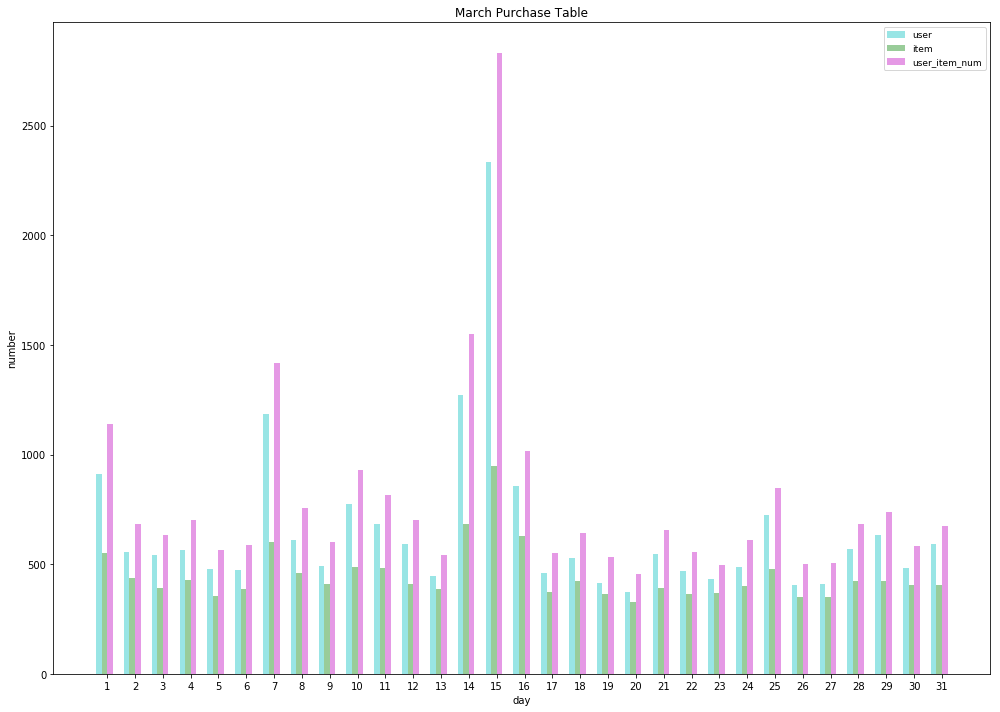

In [84]:
# 条形宽度
bar_width = 0.2
# 透明度
opacity = 0.4
# 天数
day_range = range(1,len(df_user['day']) + 1, 1)
# 设置图片大小
plt.figure(figsize=(14,10))

plt.bar(df_user['day'], df_user['user_num'], bar_width, 
        alpha=opacity, color='c', label='user')
plt.bar(df_item['day']+bar_width, df_item['item_num'], 
        bar_width, alpha=opacity, color='g', label='item')
plt.bar(df_ui['day']+bar_width*2, df_ui['user_item_num'], 
        bar_width, alpha=opacity, color='m', label='user_item_num')

plt.xlabel('day')
plt.ylabel('number')
plt.title('March Purchase Table')
plt.xticks(df_user['day'] + bar_width * 3 / 2., day_range)
# plt.ylim(0, 80)
plt.tight_layout() 
plt.legend(prop={'size':9})

分析：3月份14,15,16不知名节日，造成购物大井喷，总体来看，购物记录多于2月份

### 2016年4月

In [85]:
df_ac = get_from_action_data(fname=ACTION_201604_FILE)

# 将time字段转换为datetime类型并使用lambda匿名函数将时间time转换为天
df_ac['time'] = pd.to_datetime(df_ac['time']).apply(lambda x: x.day)

Iteration is stopped


In [86]:
df_user = df_ac.groupby('time')['user_id'].nunique()
df_user = df_user.to_frame().reset_index()
df_user.columns = ['day', 'user_num']

df_item = df_ac.groupby('time')['sku_id'].nunique()
df_item = df_item.to_frame().reset_index()
df_item.columns = ['day', 'item_num']

df_ui = df_ac.groupby('time', as_index=False).size()
df_ui = df_ui.to_frame().reset_index()
df_ui.columns = ['day', 'user_item_num']

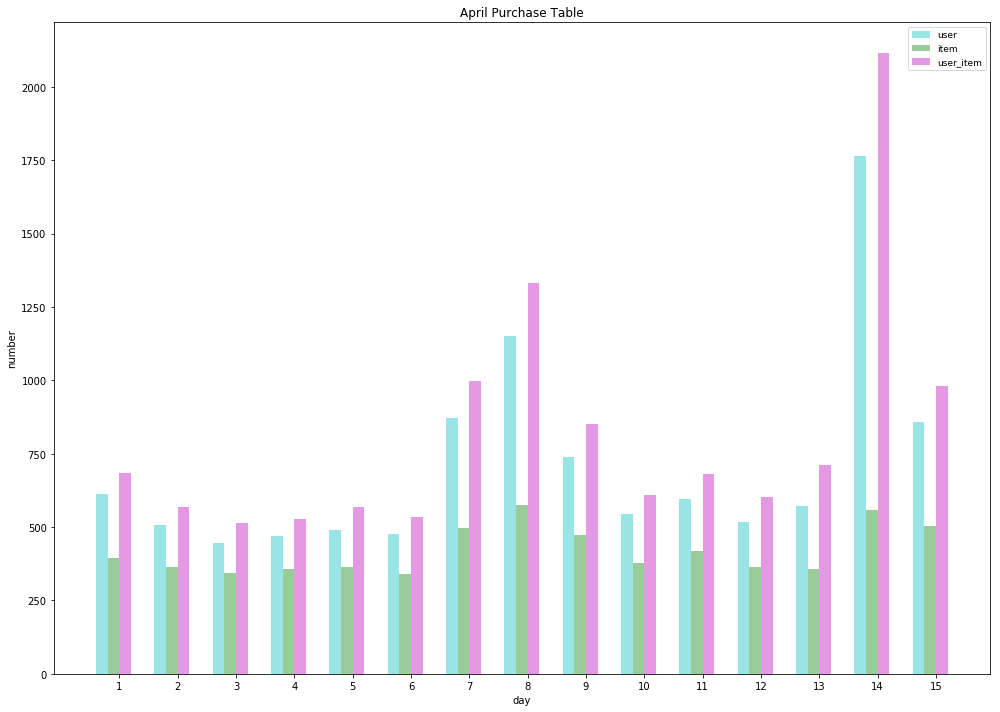

In [87]:
# 条形宽度
bar_width = 0.2
# 透明度
opacity = 0.4
# 天数
day_range = range(1,len(df_user['day']) + 1, 1)
# 设置图片大小
plt.figure(figsize=(14,10))

plt.bar(df_user['day'], df_user['user_num'], bar_width, 
        alpha=opacity, color='c', label='user')
plt.bar(df_item['day']+bar_width, df_item['item_num'], 
        bar_width, alpha=opacity, color='g', label='item')
plt.bar(df_ui['day']+bar_width*2, df_ui['user_item_num'], 
        bar_width, alpha=opacity, color='m', label='user_item')

plt.xlabel('day')
plt.ylabel('number')
plt.title('April Purchase Table')
plt.xticks(df_user['day'] + bar_width * 3 / 2., day_range)
# plt.ylim(0, 80)
plt.tight_layout() 
plt.legend(prop={'size':9})

分析：一脸懵逼中...可能又有啥节日？ 还是说每个月中旬都有较强的购物欲望？

上面做了关于时间的不同，而产生的不同的销售情况，接下来统计各商品类别的销售情况

## 商品类别销售统计

### 周一到周日各商品类别销售情况

In [88]:
# 从行为记录中提取商品类别数据
def get_from_action_data(fname, chunk_size=50000):
    reader = pd.read_csv(fname, header=0, iterator=True)
    chunks = []
    loop = True
    while loop:
        try:
            chunk = reader.get_chunk(chunk_size)[
                ["cate", "brand", "type", "time"]]
            chunks.append(chunk)
        except StopIteration:
            loop = False
            print("Iteration is stopped")

    df_ac = pd.concat(chunks, ignore_index=True)
    # type=4,为购买
    df_ac = df_ac[df_ac['type'] == 4]

    return df_ac[["cate", "brand", "type", "time"]]

In [89]:
df_ac = []
df_ac.append(get_from_action_data(fname=ACTION_201602_FILE))
df_ac.append(get_from_action_data(fname=ACTION_201603_FILE))
df_ac.append(get_from_action_data(fname=ACTION_201604_FILE))
df_ac = pd.concat(df_ac, ignore_index=True)

Iteration is stopped
Iteration is stopped
Iteration is stopped


In [90]:
# 将time字段转换为datetime类型
df_ac['time'] = pd.to_datetime(df_ac['time'])

# 使用lambda匿名函数将时间time转换为星期(周一为1, 周日为７)
df_ac['time'] = df_ac['time'].apply(lambda x: x.weekday() + 1)

In [92]:
df_ac.head(9)

,cate,brand,type,time
0,9,306,4,1
1,4,174,4,1
2,5,78,4,1
3,5,78,4,1
4,4,306,4,1
5,5,479,4,1
6,5,479,4,1
7,4,36,4,1
8,8,693,4,1


In [93]:
# 观察几个类别商品下分别有多少商品，可以发现四列都是一样的
df_ac.groupby(df_ac['cate']).count()

,cate,brand,type,time
cate,,,,
4,9326,9326,9326,9326
5,8138,8138,8138,8138
6,6982,6982,6982,6982
7,6214,6214,6214,6214
8,13281,13281,13281,13281
9,4104,4104,4104,4104
10,189,189,189,189
11,18,18,18,18


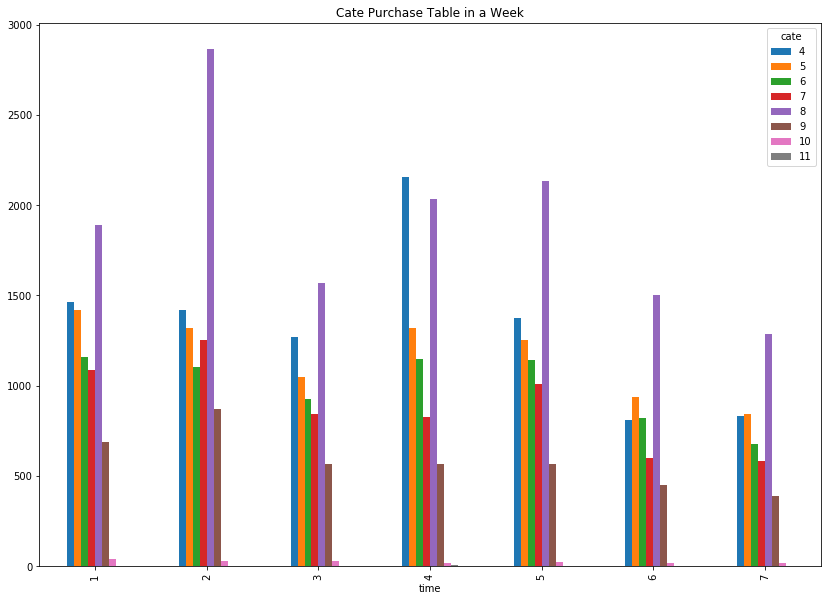

In [103]:
# 周一到周日每天购买商品类别数量统计
df_product = df_ac['brand'].groupby([df_ac['time'],df_ac['cate']]).count() 
# ↑df_ac['brand'].groupby...之所以加[‘brand’]是因为，如上表四列都是一样的，这样做相当于只取出了一列，也可以换成['type']或['cate']...
df_product=df_product.unstack() #.unstack()相当于把一个类Series的结构转化成了一个二维表横轴为cate,纵轴为time
df_product.plot(kind='bar',title='Cate Purchase Table in a Week',figsize=(14,10))

分析：星期二买类别8的最多，星期天最少。

### 每月各类商品销售情况（只关注商品8）

### 2016年2，3，4月

In [104]:
df_ac2 = get_from_action_data(fname=ACTION_201602_FILE)

# 将time字段转换为datetime类型并使用lambda匿名函数将时间time转换为天
df_ac2['time'] = pd.to_datetime(df_ac2['time']).apply(lambda x: x.day)
df_ac3 = get_from_action_data(fname=ACTION_201603_FILE)

# 将time字段转换为datetime类型并使用lambda匿名函数将时间time转换为天
df_ac3['time'] = pd.to_datetime(df_ac3['time']).apply(lambda x: x.day)
df_ac4 = get_from_action_data(fname=ACTION_201604_FILE)

# 将time字段转换为datetime类型并使用lambda匿名函数将时间time转换为天
df_ac4['time'] = pd.to_datetime(df_ac4['time']).apply(lambda x: x.day)

Iteration is stopped
Iteration is stopped
Iteration is stopped


In [105]:
dc_cate2 = df_ac2[df_ac2['cate']==8]
dc_cate2 = dc_cate2['brand'].groupby(dc_cate2['time']).count()
dc_cate2 = dc_cate2.to_frame().reset_index()
dc_cate2.columns = ['day', 'product_num']

dc_cate3 = df_ac3[df_ac3['cate']==8]
dc_cate3 = dc_cate3['brand'].groupby(dc_cate3['time']).count()
dc_cate3 = dc_cate3.to_frame().reset_index()
dc_cate3.columns = ['day', 'product_num']

dc_cate4 = df_ac4[df_ac4['cate']==8]
dc_cate4 = dc_cate4['brand'].groupby(dc_cate4['time']).count()
dc_cate4 = dc_cate4.to_frame().reset_index()
dc_cate4.columns = ['day', 'product_num']

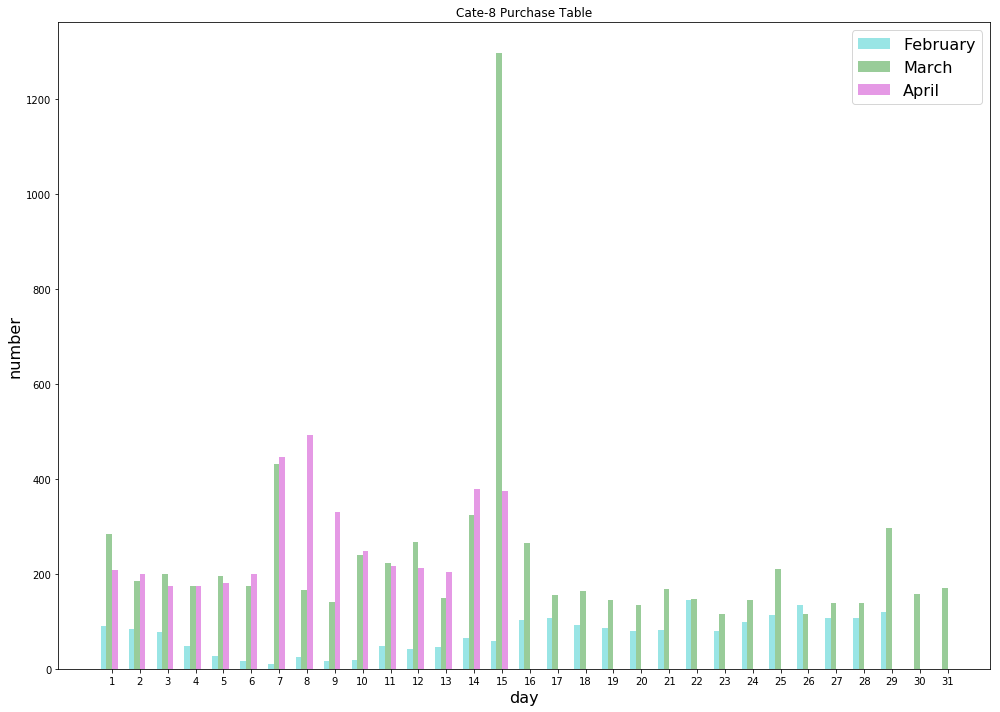

In [111]:
# 条形宽度
bar_width = 0.2
# 透明度
opacity = 0.4
# 天数
day_range = range(1,len(dc_cate3['day']) + 1, 1)
# 设置图片大小
plt.figure(figsize=(14,10))

plt.bar(dc_cate2['day'], dc_cate2['product_num'], bar_width, 
        alpha=opacity, color='c', label='February')
plt.bar(dc_cate3['day']+bar_width, dc_cate3['product_num'], 
        bar_width, alpha=opacity, color='g', label='March')
plt.bar(dc_cate4['day']+bar_width*2, dc_cate4['product_num'], 
        bar_width, alpha=opacity, color='m', label='April')

plt.xlabel('day',{'size':'16'})
plt.ylabel('number',{'size':'16'})
plt.title('Cate-8 Purchase Table')
plt.xticks(dc_cate3['day'] + bar_width * 3 / 2., day_range)
# plt.ylim(0, 80)
plt.tight_layout() 
plt.legend(prop={'size':16})

分析：2月份对类别8商品的购买普遍偏低，3，4月份普遍偏高，3月15日购买极其多！可以对比3月份的销售记录，发现类别8将近占了3月15日总销售的一半！同时发现，3,4月份类别8销售记录在前半个月特别相似，除了4月8号，9号和3月15号。

### 查看特定用户(specific user)对特定商品(particular commodity)的的轨迹

In [112]:
def spec_ui_action_data(fname, user_id, item_id, chunk_size=100000):
    reader = pd.read_csv(fname, header=0, iterator=True)
    chunks = []
    loop = True
    while loop:
        try:
            chunk = reader.get_chunk(chunk_size)[
                ["user_id", "sku_id", "type", "time"]]
            chunks.append(chunk)
        except StopIteration:
            loop = False
            print("Iteration is stopped")

    df_ac = pd.concat(chunks, ignore_index=True)
    df_ac = df_ac[(df_ac['user_id'] == user_id) & (df_ac['sku_id'] == item_id)]

    return df_ac

In [113]:
def explore_user_item_via_time():
    user_id = 266079
    item_id = 138778
    df_ac = []
    df_ac.append(spec_ui_action_data(ACTION_201602_FILE, user_id, item_id))
    df_ac.append(spec_ui_action_data(ACTION_201603_FILE, user_id, item_id))
    df_ac.append(spec_ui_action_data(ACTION_201604_FILE, user_id, item_id))
    df_ac = pd.concat(df_ac, ignore_index=False)
    print(df_ac.sort_values(by='time'))

In [114]:
explore_user_item_via_time()

Iteration is stopped
Iteration is stopped
Iteration is stopped
    user_id  sku_id  type                 time
0    266079  138778     1  2016-01-31 23:59:02
1    266079  138778     6  2016-01-31 23:59:03
15   266079  138778     6  2016-01-31 23:59:40
